In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from matplotlib import pyplot as plt
import torch

from grconvnet.dataloading.datasets import YCBSimulationData
from grconvnet.preprocessing import Preprocessor
from grconvnet.postprocessing import Postprocessor, Img2WorldConverter, GraspHeightAdjuster, Img2WorldCoordConverter, Decropper
from grconvnet.utils.processing import End2EndProcessor
from grconvnet.utils import visualization as vis
from grconvnet.utils.export import Exporter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
dataset_path = Path("/home/moritz/Documents/ycb_sim_data_1")
dataset = YCBSimulationData(dataset_path)
sample = dataset[-1]
sample.name

'ycb_simulation_sample_089_rubiks_cube'

In [3]:
cam_intrinsics = sample.cam_intrinsics
cam_pos = sample.cam_pos
cam_rot = sample.cam_rot
image_size = sample.rgb.shape[1:]

In [4]:
resize = True

e2e_processor = End2EndProcessor(
    preprocessor=Preprocessor(
        mask_rgb_neg_color=torch.Tensor([255, 255, 255]),
        mask_rgb_pos_color=torch.Tensor([0, 0, 0]),
        resize=resize,
    ),
    postprocessor=Postprocessor(n_grasps=3),
    img2world_converter=Img2WorldConverter(
        coord_converter=Img2WorldCoordConverter(
            cam_intrinsics,
            cam_rot,
            cam_pos,
        ),
        decropper=Decropper(
            resized_in_preprocess = resize,
            original_img_size = image_size
        ),
        height_adjuster=GraspHeightAdjuster(
            min_height=0.01,
            target_grasp_depth=0.04,
        ),
    ),
)


In [5]:
process_data = e2e_processor(sample)
print(list(process_data.keys()))
print(list(process_data["preprocessor"].keys()))
print(list(process_data["postprocessor"].keys()))
print(list(process_data["img2world_converter"].keys()))

['preprocessor', 'postprocessor', 'img2world_converter', 'model_input', 'sample', 'grasps_img', 'grasps_world']
['rgb_cropped', 'depth_cropped', 'seg_cropped', 'rgb_masked', 'rgb_norm', 'depth_norm']
['q_img', 'angle_img', 'width_img']
['antipodal_points_world', 'grasp_decropped', 'center_depth', 'grasp_world_raw']


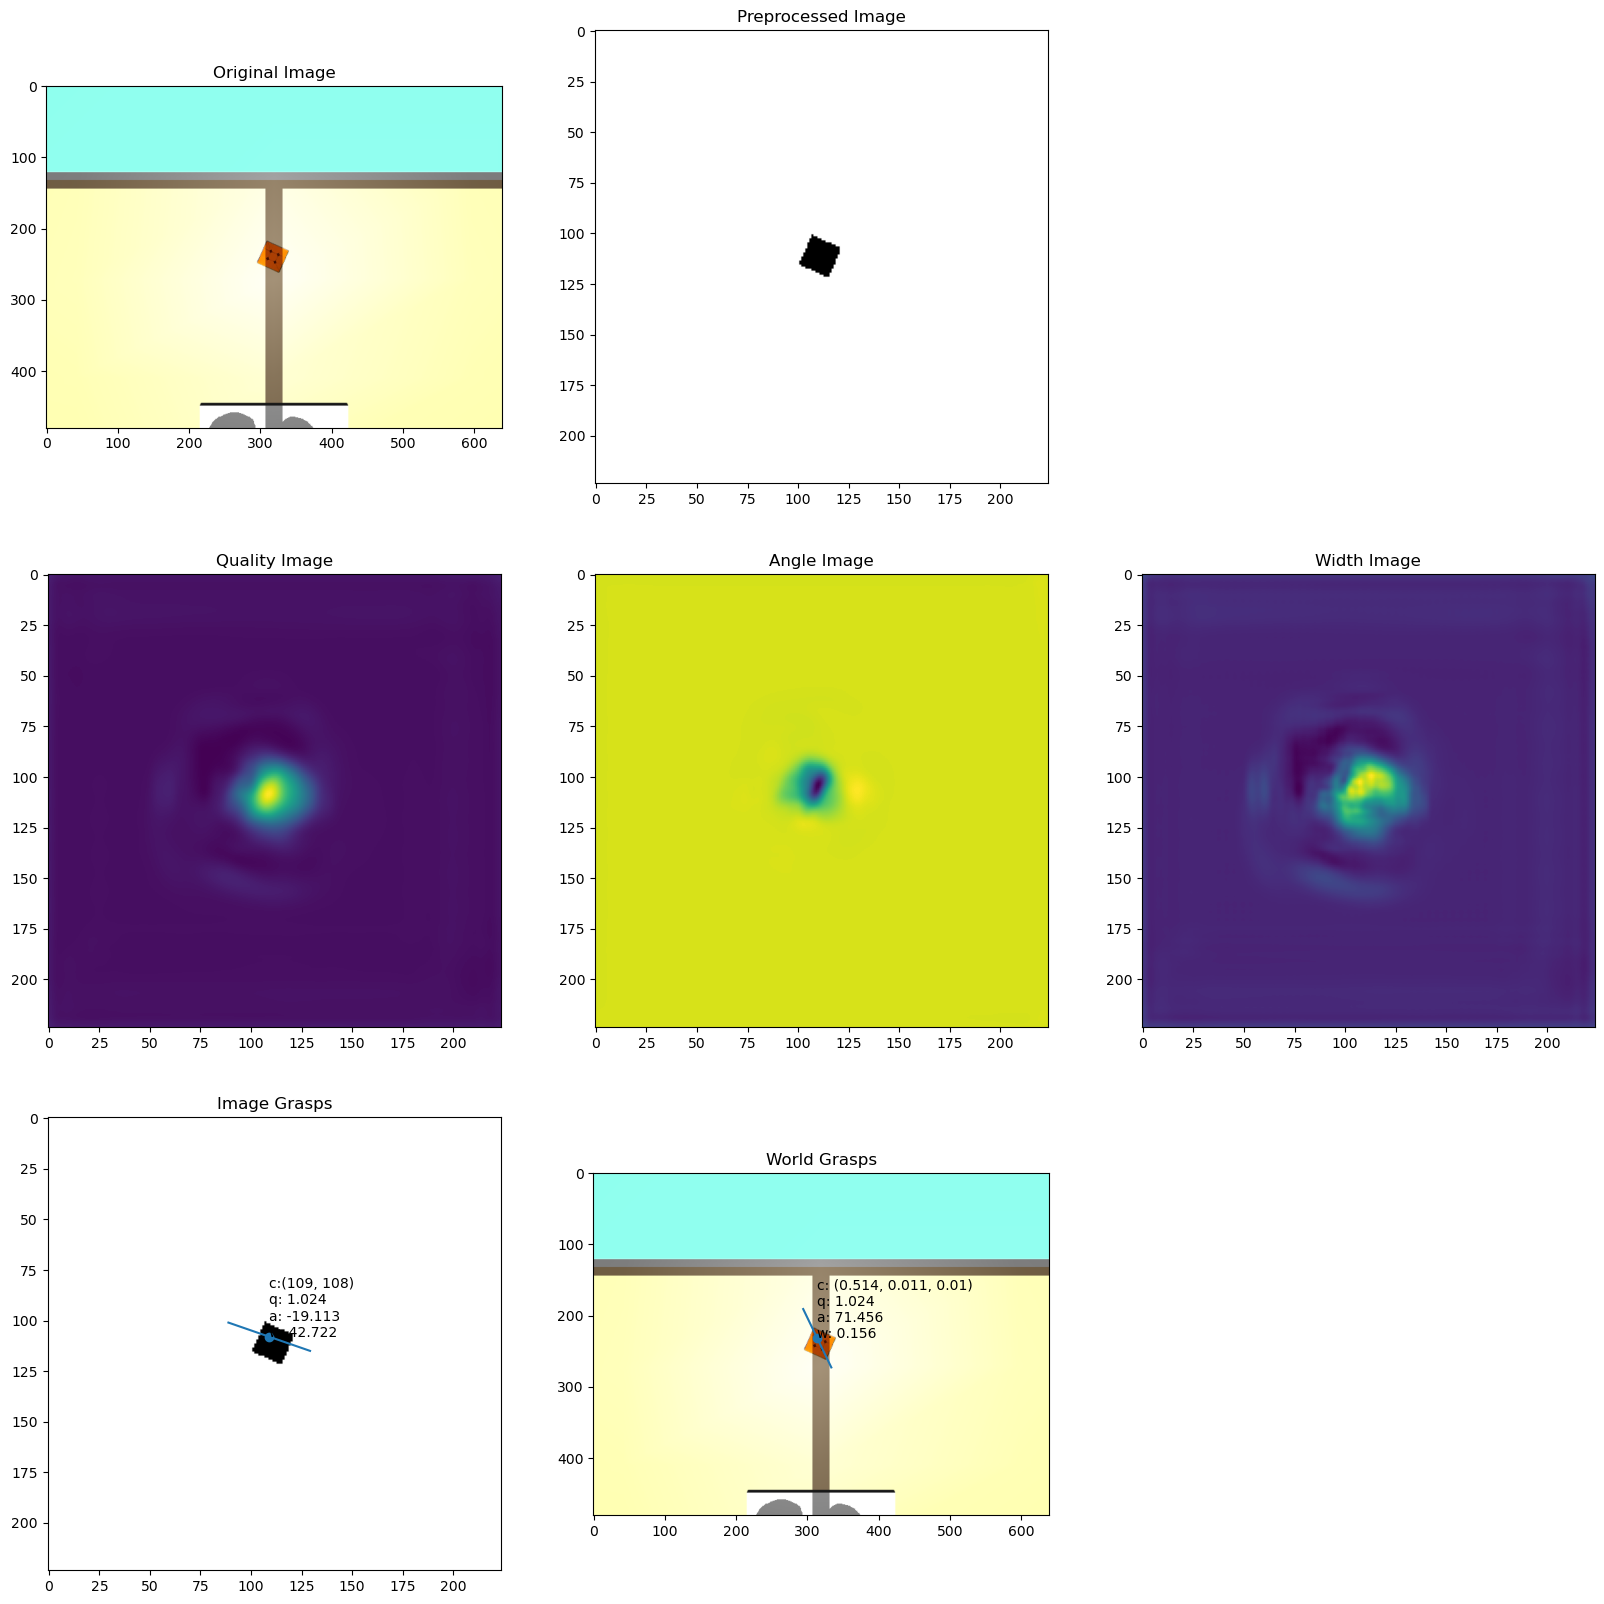

In [25]:
fig = vis.overview_fig(
    fig=plt.figure(figsize=(20, 20)),
    original_rgb=vis.make_tensor_displayable(process_data["sample"].rgb, True, True),
    preprocessed_rgb=vis.make_tensor_displayable(
        process_data["preprocessor"]["rgb_masked"], True, True
    ),
    q_img=vis.make_tensor_displayable(
        process_data["postprocessor"]["q_img"], False, False
    ),
    angle_img=vis.make_tensor_displayable(
        process_data["postprocessor"]["angle_img"], False, False
    ),
    width_img=vis.make_tensor_displayable(
        process_data["postprocessor"]["width_img"], False, False
    ),
    image_grasps=process_data["grasps_img"],
    world_grasps=process_data["grasps_world"],
    cam_intrinsics=cam_intrinsics,
    cam_rot=cam_rot,
    cam_pos=cam_pos,
)

plt.show()

In [8]:
print(process_data["img2world_converter"]["antipodal_points_world"])

[array([0.53909814, 0.0851736 , 0.03844541]), array([ 0.48935107, -0.0631304 ,  0.03844541])]


[[270.32077816 216.44033886]
 [356.82207898 246.416804  ]]


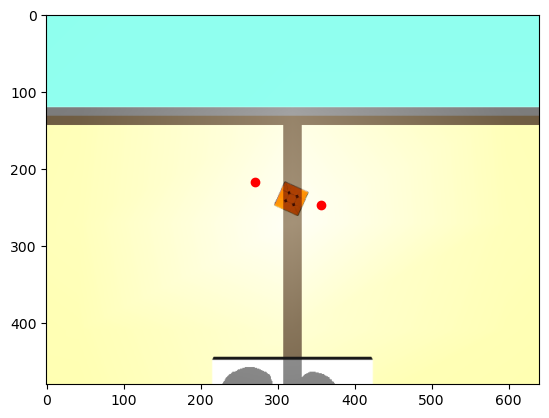

In [22]:
from grconvnet.postprocessing import World2ImgCoordConverter
import numpy as np

plt.imshow(vis.make_tensor_displayable(process_data["sample"].rgb, True, True))
converter = World2ImgCoordConverter(cam_intrinsics, cam_rot, cam_pos)
antipodal_points_img = np.array([converter(p) for p in process_data["img2world_converter"]["antipodal_points_world"]])
print(antipodal_points_img)
plt.scatter(antipodal_points_img[:,0], antipodal_points_img[:,1], c="r")

In [7]:
# export_data = {
#     "rgb_cropped": process_data["preprocessor"]["rgb_cropped"],
#     "depth_cropped": process_data["preprocessor"]["depth_cropped"],
#     "rgb_masked": process_data["preprocessor"]["rgb_masked"],
#     "q_img": process_data["postprocessor"]["q_img"],
#     "angle_img": process_data["postprocessor"]["angle_img"],
#     "width_img": process_data["postprocessor"]["width_img"],
#     "grasps_img": process_data["grasps_img"],
#     "grasps_world": process_data["grasps_world"],
#     "model_input": process_data["model_input"],
#     "overview": fig,
#     "_export_name": f"processing_simulation_world_{process_data['sample'].name}",
# }

# exporter = Exporter(export_dir=Path.cwd().parent / "grconvnet" / "results" / "test")
# export_path = exporter(export_data)